In [1]:
import torch
from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,#단어 사전의 크기
        hidden_dim,# 은닉차원
        embedding_dim,#임베딩 차원
        n_layers,#신경망의 층
        dropout=0.5,#드롭아웃 비율
        bidirectional=True,#양방향 설정
        model_type="lstm",#모델은 lstm
        pretrained_embedding=None#이미 임베딩이 있는지 확인
    ):
        super().__init__()#상속받은 클래스의 init호출
        if pretrained_embedding is not None:#만약 이미 학습된 임베딩 모델이 있다면 이미 학습된 임베딩 모델을 쓰겠다는 뜻
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embedding, dtype=torch.float32)
            )
        else:#없다면 파이토치 임베딩 레이어 사용
            self.embedding = nn.Embedding(
                num_embeddings=n_vocab,
                embedding_dim=embedding_dim,
                padding_idx=0
            )
        
        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [3]:
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
corpus_df = pd.DataFrame(corpus.test)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:02, 7.14MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:01, 4.05MB/s]                            


In [6]:
train = corpus_df.sample(frac=0.9, random_state=42)#샘플 수에 0.9만큼의 비율을 가져옴
test = corpus_df.drop(train.index)#train의 인덱스를 제외한거를 가져옴
print(train.head(5).to_markdown())#맨앞에 5개의 정보만 가져오겠다.
print("Training Data Size :", len(train))
print("Testing Data Size :", len(test))

Index([33553,  9427,   199, 12447, 39489, 42724, 10822, 49498,  4144, 36958,
       ...
        5232, 30453, 45641, 30257, 35595, 22164, 44594,  4996,  3262,  6838],
      dtype='int64', length=45000)
|       | text                                                                                     |   label |
|------:|:-----------------------------------------------------------------------------------------|--------:|
| 33553 | 모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만 영원하라. |       1 |
|  9427 | 무한 리메이크의 소재. 감독의 역량은 항상 그 자리에...                                    |       0 |
|   199 | 신날 것 없는 애니.                                                                       |       0 |
| 12447 | 잔잔 격동                                                                                |       1 |
| 39489 | 오랜만에 찾은 주말의 명화의 보석                                                         |       1 |
Training Data Size : 45000
Testing Data Size : 5000


In [7]:
from konlpy.tag import Okt
from collections import Counter
#리스트나 딕셔너리에 특정 원소가 몇개 있는지 세줌

def build_vocab(corpus, n_vocab, special_tokens):#단어 사전 구축
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)# 추가된 리스트를 누적히여 셈
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    #가장 흔한 데이터 순으로 정렬 https://www.daleseo.com/python-collections-counter/ <--참고
    return vocab


tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in train.text]
test_tokens = [tokenizer.morphs(review) for review in test.text]
#형태소로 토큰화
print(train_tokens[:10])
vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>", "<unk>"])
#단어사전 구축
token_to_id = {token: idx for idx, token in enumerate(vocab)}
#토큰을 통해 인덱스를 찾아내는 딕셔너리 생성
id_to_token = {idx: token for idx, token in enumerate(vocab)}
#인덱스를 통해 토큰을 찾아내는 딕셔너리 생성

print(vocab[:10])
print(len(vocab))

[['모든', '편견', '을', '날려', '버리는', '가슴', '따뜻한', '영화', '.', '로버트', '드', '니', '로', ',', '필립', '세이모어', '호프만', '영원하라', '.'], ['무한', '리메이크', '의', '소재', '.', '감독', '의', '역량', '은', '항상', '그', '자리', '에', '...'], ['신날', '것', '없는', '애니', '.'], ['잔잔', '격동'], ['오랜', '만', '에', '찾은', '주말', '의', '명화', '의', '보석'], ['영화', '공사', '중', '도로', '를', '보았는데', '에어컨', '을', '..', '정말', '더웠다', '.', '하지만', '더글라스', '오빠', '연기', '압권'], ['재밌다', '.', '유쾌한', '노랫소리', '.', '주인공', '들', '의', '코믹', '한', '연기', '.', '굿굿'], ['음', '..', '괜찮네요', '.', '생각', '보다', '좋았어요'], ['"""', '21', '세기', '""""', '레', '니', '할', '린', ',', '작품', '은', '""""', '마인', '트', '헌터', ',', '뿐', '인가', '!?', '연출', '이', 'tv', '판', '수준', '!"""'], ['이', '걸', '영화관', '에서', '보다니', '감동', '이었고', '관객', '이', '다', '들', '혼자', '온', '덕후', '들', '이라', '더욱', '감개', '무량', '했던', '순간', '이었습니다', '.', '바트', '넘', '멋져', '부러']]
['<pad>', '<unk>', '.', '이', '영화', '의', '..', '가', '에', '...']
5002


In [9]:
import numpy as np


def pad_sequences(sequences, max_length, pad_value):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
    return np.asarray(result)
#32의 길이를 맞추기 위해 패딩

unk_id = token_to_id["<unk>"]
train_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in train_tokens
]
#토큰 데이터의 토큰을 단어 사전의 인덱스로 반환 만약 단어사전에 없을시 unk의 인덱스 반환
test_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in test_tokens
]
#토큰 데이터의 토큰을 단어 사전의 인덱스로 반환 만약 단어사전에 없을시 unk의 인덱스 반환
max_length = 32
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

1
[ 223 1716   10 4036 2095  193  755    4    2 2330 1031  220   26   13
 4839    1    1    1    2    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[3307    5 1997  456    8    1 1013 3906    5    1    1   13  223   51
    3    1 4684    6    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [10]:
from torch.utils.data import TensorDataset, DataLoader


train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)
#텐서로 변환
train_labels = torch.tensor(train.label.values, dtype=torch.float32)
test_labels = torch.tensor(test.label.values, dtype=torch.float32)
print(train_labels,test_labels)
#라벨 데이터 얻음
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)
#데이터 셋 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
#로더 설정

tensor([1., 0., 0.,  ..., 0., 1., 1.]) tensor([1., 1., 0.,  ..., 1., 1., 0.])


In [11]:
n_vocab = len(token_to_id)#5002
hidden_dim = 64#은닉 상태 타원
embedding_dim = 128#임베딩 차원
n_layers = 2

5002


In [14]:

tokenizer = Okt()
tokens = [tokenizer.morphs(review) for review in train.text]


In [15]:
from gensim.models import Word2Vec
word2vec = Word2Vec(
    sentences=tokens,
    vector_size=128,#임베딩 된 벡터 차원
    window=5,#윈도우 크기
    min_count=1,#단어의 최소 빈도수 빈도가 적은 단어들은 학습 x
    sg=1,#Skip-gram을 사용하겠다는 뜻 당연히 0이면  CBoW
    epochs=3,
    max_final_vocab=10000 #빈도 순 단어 내림차순 정렬 후 정렬된 단어중 max_final_vocab index 자리의 단어 빈도와 min_count중 큰 값을 min_count로 지정
    #한마디로 min count를 치환, 단어 마지노선을 상향하겠다는 의미
    #참고자료:https://hoonzi-text.tistory.com/2
)

init_embeddings = np.zeros((n_vocab, embedding_dim))

for index, token in id_to_token.items():
    if token not in ["<pad>", "<unk>"]:
        init_embeddings[index] = word2vec.wv[token]
#단어 사전을 워드투백으로 임베딩한 값 생성
embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(init_embeddings, dtype=torch.float32)
)

In [16]:
print(init_embeddings.shape)

(5002, 128)


In [17]:
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        #단어 사전의 인덱스 값 형태인 입력값 설정
        #라벨 값에 1차원을 추가함 ex(3,4)-->(1,3,4) 참고자료:https://jimmy-ai.tistory.com/110
        logits = model(input_ids)#모델 순전파
        loss = criterion(logits, labels)#손실값구함
        losses.append(loss.item())

        optimizer.zero_grad()
        #가중치 초기화
        loss.backward()
        #역전파
        optimizer.step()
        #가중치 업데이트

        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")


def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5
        #출력값 시그모이드 함수 통과
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")

In [18]:
from torch import optim


device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, 
n_layers=n_layers, pretrained_embedding=init_embeddings
).to(device) #모델 정의
criterion = nn.BCEWithLogitsLoss().to(device)#손실 함수 정의
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)
#옵티마이저
epochs = 5
interval = 500

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6997377872467041
Train Loss 500 : 0.6614526964709192
Train Loss 1000 : 0.5965140030517445
Train Loss 1500 : 0.5746445728889074
Train Loss 2000 : 0.559323578879334
Train Loss 2500 : 0.5464668736511209
Val Loss : 0.47347283501404164, Val Accuracy : 0.7804
Train Loss 0 : 0.6353675127029419
Train Loss 500 : 0.49205217752865926
Train Loss 1000 : 0.48839313559956127
Train Loss 1500 : 0.48441855770242287
Train Loss 2000 : 0.48172992039685963
Train Loss 2500 : 0.47861969115280334
Val Loss : 0.44926272256496236, Val Accuracy : 0.7914
Train Loss 0 : 0.5498812794685364
Train Loss 500 : 0.4698312818230745
Train Loss 1000 : 0.4595781006328352
Train Loss 1500 : 0.45989138633509147
Train Loss 2000 : 0.4572534009419579
Train Loss 2500 : 0.4565079646592424
Val Loss : 0.4339439758001425, Val Accuracy : 0.7996
Train Loss 0 : 0.3412971794605255
Train Loss 500 : 0.43767992566207686
Train Loss 1000 : 0.4383460546766485
Train Loss 1500 : 0.44374014503712816
Train Loss 2000 : 0.43877283291987

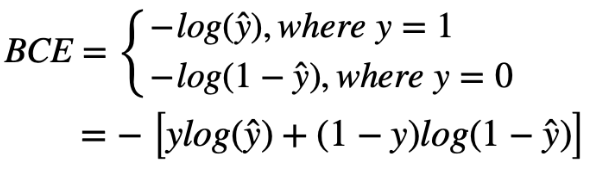